# SETUP

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [2]:
def learning_curve(history):
    hist = history.history
    train_loss, val_loss = hist["loss"], hist["val_loss"]

    fig = plt.figure(figsize = (6, 6))
    plt.style.use("seaborn-dark")

    plt.plot(range(len(train_loss)), train_loss, label = "train_loss")
    plt.plot(range(len(train_loss)), val_loss, label = "val_loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.tight_layout()
    plt.show()

# Variational Autoencoder
### 개념설명
* 인코딩 표현이 학습되는데에 제약이 추가된 autoencoder -> input data에 대한 latent variable model을 학습하는 AE
* 네트워크가 임의의 함수를 학습하는 것이 아니라 데이터의 확률분포를 모델링하는 파라미터를 학습한다.
* 이 분포로부터 샘플링을 하면, 새로운 input data sample을 생성할 수 있다.
* 이런 맥락에서VAE는 generative model이다.
---
### 작동방식
1. 인코더 네트워크가 input sample들을 latent sapce의 두 개의 파라미터 z_mean, z_log_sigma로 변환한다.
2. latent normal 분포로부터 z = z_mean + exp(z_log_sigma) * epsilon의 방식으로 input과 유사한 데이터를 샘플링한다.
3. 디코더 네트워크가 이 latent space의 관측을 원본 input data에 매핑한다.

* 모델의 파라미터는 2개의 loss function을 통해 training 되는데,
  * 재구성손실 : decoding된 샘플이 초기 input과 매치되도록 이끔
  * KL발산 : 학습된 latent distribution과 prior distribution간의 차이를 줄이는 방식으로 작동
(이 part는 사용하지 않을 수 있다.)

# Tutorial 1
https://blog.keras.io/building-autoencoders-in-keras.html

### 1. mapping inputs to the latent distribution parameters

In [4]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape = (original_dim, ))                    # input layer
h = layers.Dense(intermediate_dim, activation = "relu")(inputs)   # hidden layer
z_mean = layers.Dense(latent_dim)(h)                              # mean이 학습되는 2개의 node
z_log_sigma = layers.Dense(latent_dim)(h)                         # std가 학습되는 2개의 node

### 2. sampling new similar points from the latent space

In [5]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim),
                              mean = 0., stddev = 0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

### 3. map sampled latent points back to reconstructed inputs

In [6]:
# create encoder - mapping inputs to the latent space
encoder = keras.Model(inputs = inputs, 
                      outputs = [z_mean, z_log_sigma, z], 
                      name = "encoder")

# create decoder - generator that can take points on the latent space 
#                  and will output the corresponding reconstructed samples
latent_inputs = keras.Input(shape = (latent_dim,), name = "z_sampling")
x = layers.Dense(intermediate_dim, activation = "relu")(latent_inputs)
decoded_outputs = layers.Dense(original_dim, activation = "sigmoid")(x)
decoder = keras.Model(inputs = latent_inputs,
                      outputs = decoded_outputs,
                      name = "decoder")

# instantiate VAE model - an end-to-end autoencoder mapping inputs to reconstructions
outputs = decoder(encoder(inputs)[2]) # sampling한 z를 decoder에 input
vae = keras.Model(inputs, outputs, name = "vae_mlp")

In [7]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis = -1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer = "adam")

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        verbose = 0,
        validation_data=(x_test, x_test))

### Visualizing Latent Space

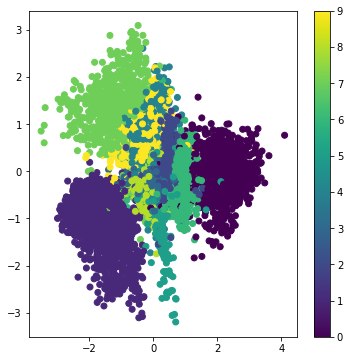

In [40]:
# 학습된 encoder network를 이용하여 test set을 latent space로 매핑
enc_z_mean, enc_z_log_sigma, enc_z = encoder.predict(x_test)

# 관측별 latent space의 각 차원 value 값을 표시, class label로 구분하여 시각화
plt.figure(figsize=(6, 6))
plt.scatter(enc_z_mean[:,0], enc_z_mean[:,1], c = y_test)
plt.colorbar()
plt.show()

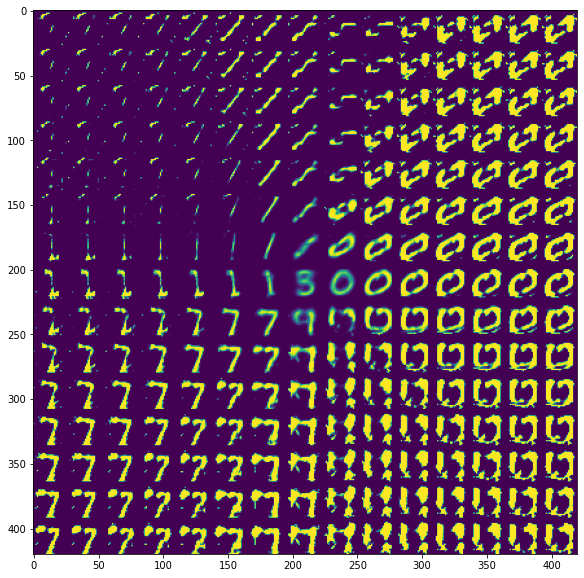

In [41]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()